# Face Detection 

In [1]:
# %pip install labelme

## Imports

In [2]:
!cp -r  /kaggle/input/facedet ./

In [3]:
import os
import time
import uuid #Unique identifier|
import cv2
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import random
import shutil
import albumentations as A
import wandb


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Uncomment to create the images using web cam
# IMAGES_PATH = os.path.join('data', 'images')
# number_images = 30

In [4]:
KAGGLE_PATH = '/kaggle/working/facedet'
labels_path = os.path.join(KAGGLE_PATH, 'face_labels')
bs=' ' # blank-space
class_id=0 # id for face
newline='\n' # new line character

In [5]:
# Uncomment to create the images using web cam
# cap = cv2.VideoCapture(1)
# cv2.startWindowThread()
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname,frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()
# for i in range (1,5):
#     cv2.waitKey(1)

In [5]:
# Uncomment to open labelme and label created files
# !labelme

## Preparing the data

In [6]:
import glob
image_files = glob.glob(os.path.join(KAGGLE_PATH,'images/*.jpg'))

images = [os.path.basename(file) for file in image_files]

In [7]:
len(images)

90

In [8]:
df = pd.DataFrame({'image': images})

In [9]:
df.head()

,image
0,928f87ea-6110-11ee-a747-d68c087a5dfe.jpg
1,978508b0-6110-11ee-a747-d68c087a5dfe.jpg
2,1386ba86-6110-11ee-a747-d68c087a5dfe.jpg
3,95dd04ae-6110-11ee-a747-d68c087a5dfe.jpg
4,99db333c-6110-11ee-a747-d68c087a5dfe.jpg


In [10]:
def get_label_file(image_name):
    image_name = image_name.split('.')[0]
    label_files = glob.glob(os.path.join(KAGGLE_PATH,'labels',image_name+'.json'))
    return os.path.basename(label_files[0]) if label_files else None

In [11]:
df['label'] = df['image'].apply(get_label_file)

In [12]:
df.head()

,image,label
0,928f87ea-6110-11ee-a747-d68c087a5dfe.jpg,928f87ea-6110-11ee-a747-d68c087a5dfe.json
1,978508b0-6110-11ee-a747-d68c087a5dfe.jpg,978508b0-6110-11ee-a747-d68c087a5dfe.json
2,1386ba86-6110-11ee-a747-d68c087a5dfe.jpg,1386ba86-6110-11ee-a747-d68c087a5dfe.json
3,95dd04ae-6110-11ee-a747-d68c087a5dfe.jpg,95dd04ae-6110-11ee-a747-d68c087a5dfe.json
4,99db333c-6110-11ee-a747-d68c087a5dfe.jpg,None


In [13]:
df['x0'], df['y0'], df['x1'],df['y1'] = None, None, None, None

In [14]:
for i, label in enumerate(df.label):
    if label:
        with open(os.path.join(KAGGLE_PATH, 'labels', label), 'r') as f:
            label_json = json.load(f)
        coor = label_json["shapes"][0]["points"]
        x0, y0 = coor[0]
        x1, y1 = coor[1]
        df['x0'][i] = x0
        df['x1'][i] = x1
        df['y0'][i] = y0
        df['y1'][i] = y1

In [15]:
df.drop(axis=1, labels='label', inplace=True)

In [16]:
img = cv2.imread(os.path.join(KAGGLE_PATH, 'images','9732701e-6110-11ee-a747-d68c087a5dfe.jpg'))


In [17]:
height, width, _ = np.shape(img)

In [18]:
df['x0_scaled']=df['x0']/width
df['y0_scaled']=df['y0']/height
df['x1_scaled']=df['x1']/width
df['y1_scaled']=df['y1']/height

In [19]:
df

,image,x0,y0,x1,y1,x0_scaled,y0_scaled,x1_scaled,y1_scaled
0,928f87ea-6110-11ee-a747-d68c087a5dfe.jpg,901.447368,542.631579,1234.342105,996.578947,0.469504,0.502437,0.642887,0.922758
1,978508b0-6110-11ee-a747-d68c087a5dfe.jpg,843.552632,266.315789,1240.921053,836.052632,0.43935,0.246589,0.646313,0.774123
2,1386ba86-6110-11ee-a747-d68c087a5dfe.jpg,968.552632,359.736842,1459.342105,929.473684,0.504454,0.33309,0.760074,0.860624
3,95dd04ae-6110-11ee-a747-d68c087a5dfe.jpg,838.289474,649.210526,1105.394737,988.684211,0.436609,0.601121,0.575726,0.915448
4,99db333c-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
85,19395466-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN
86,9882f826-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN
87,142e845a-6110-11ee-a747-d68c087a5dfe.jpg,969.868421,309.736842,1525.131579,979.473684,0.50514,0.286793,0.794339,0.90692
88,cf51ea9c-6110-11ee-a747-d68c087a5dfe.jpg,1011.973684,429.473684,1558.026316,1036.052632,0.52707,0.397661,0.811472,0.959308


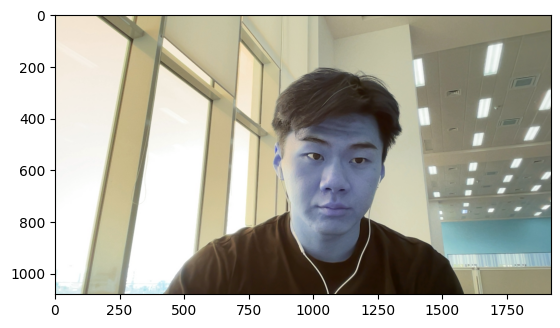

In [20]:
plt.imshow(img)

In [21]:
img_row = df[df.image=='9732701e-6110-11ee-a747-d68c087a5dfe.jpg']

In [22]:
coords = [0,0,0,0]

coords[0] = img_row.x0_scaled.iloc[0]
coords[1] = img_row.y0_scaled.iloc[0]
coords[2] = img_row.x1_scaled.iloc[0]
coords[3] = img_row.y1_scaled.iloc[0]
coords

[0.4338678728070176,
 0.1795808966861598,
 0.6737253289473684,
 0.7923976608187133]

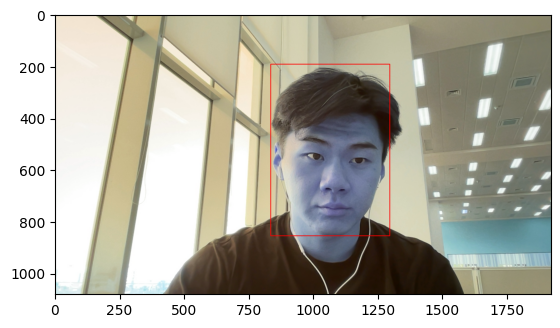

In [23]:
cv2.rectangle(img, 
              tuple(np.multiply(coords[:2], [width,height]).astype(int)),
              tuple(np.multiply(coords[2:],  [width,height]).astype(int)),
                    (255,0,0), 2)

plt.imshow(img)

In [24]:
df['x_center_scaled']=0.5*(df['x0_scaled']+df['x1_scaled'])
df['y_center_scaled']=0.5*(df['y0_scaled']+df['y1_scaled'])
df['bb_width_scaled']=df['x1_scaled']-df['x0_scaled']
df['bb_height_scaled']=df['y1_scaled']-df['y0_scaled']
df

,image,x0,y0,x1,y1,x0_scaled,y0_scaled,x1_scaled,y1_scaled,x_center_scaled,y_center_scaled,bb_width_scaled,bb_height_scaled
0,928f87ea-6110-11ee-a747-d68c087a5dfe.jpg,901.447368,542.631579,1234.342105,996.578947,0.469504,0.502437,0.642887,0.922758,0.556195,0.712597,0.173383,0.420322
1,978508b0-6110-11ee-a747-d68c087a5dfe.jpg,843.552632,266.315789,1240.921053,836.052632,0.43935,0.246589,0.646313,0.774123,0.542832,0.510356,0.206963,0.527534
2,1386ba86-6110-11ee-a747-d68c087a5dfe.jpg,968.552632,359.736842,1459.342105,929.473684,0.504454,0.33309,0.760074,0.860624,0.632264,0.596857,0.25562,0.527534
3,95dd04ae-6110-11ee-a747-d68c087a5dfe.jpg,838.289474,649.210526,1105.394737,988.684211,0.436609,0.601121,0.575726,0.915448,0.506168,0.758285,0.139117,0.314327
4,99db333c-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,19395466-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,9882f826-6110-11ee-a747-d68c087a5dfe.jpg,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,142e845a-6110-11ee-a747-d68c087a5dfe.jpg,969.868421,309.736842,1525.131579,979.473684,0.50514,0.286793,0.794339,0.90692,0.64974,0.596857,0.2892,0.620127
88,cf51ea9c-6110-11ee-a747-d68c087a5dfe.jpg,1011.973684,429.473684,1558.026316,1036.052632,0.52707,0.397661,0.811472,0.959308,0.669271,0.678484,0.284402,0.561647


In [25]:
img_row = df[df.image=='142e845a-6110-11ee-a747-d68c087a5dfe.jpg']

In [26]:
x_center = img_row.x_center_scaled.iloc[0]
y_center = img_row.y_center_scaled.iloc[0]
bb_width_scaled = img_row.bb_width_scaled.iloc[0]
bb_height_scaled = img_row.bb_height_scaled.iloc[0]

In [27]:
x0=(float(x_center)-(float(bb_width_scaled)/2))*width
y0=(float(y_center)+(float(bb_height_scaled)/2))*height
x1=(float(x_center)+(float(bb_width_scaled)/2))*width
y1=(float(y_center)-(float(bb_height_scaled)/2))*height

In [28]:
img = cv2.imread(os.path.join(KAGGLE_PATH, 'images','142e845a-6110-11ee-a747-d68c087a5dfe.jpg'))

In [29]:
first_coor = [int(x0),int(y0)]
sec_coor = [int(x1),int(y1)]

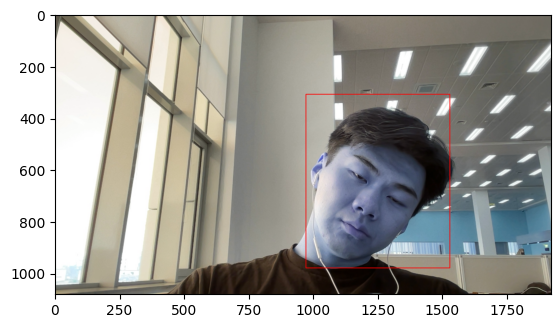

In [30]:
cv2.rectangle(img, 
              tuple(first_coor),
              tuple(sec_coor),
                    (255,0,0), 2)
plt.imshow(img)

In [31]:
imgs = df.groupby('image')

In [32]:
os.makedirs(os.path.join(KAGGLE_PATH,'face_labels'), exist_ok=True)

In [33]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+'.txt'
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    if img_df.x0.iloc[0] ==None:
        continue
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(class_id)+bs+str(row['x_center_scaled'])+bs+str(row['y_center_scaled'])+bs+str(row['bb_width_scaled'])+bs+str(row['bb_height_scaled'])+newline
            lines.append(line)
        else:
            line=str(class_id)+bs+str(row['x_center_scaled'])+bs+str(row['y_center_scaled'])+bs+str(row['bb_width_scaled'])+bs+ str(row['bb_height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [34]:
label_files = glob.glob(os.path.join(KAGGLE_PATH,'face_labels/*.txt'))
labels = [os.path.basename(file) for file in label_files]

In [35]:
len(labels)

72

### Spliting the data

In [36]:
curr_path=os.getcwd()
move_path = os.path.join(curr_path,KAGGLE_PATH)
train_dir = os.path.join(curr_path,KAGGLE_PATH,'train','images')
val_dir=os.path.join(curr_path,KAGGLE_PATH,'validation','images')
test_dir=os.path.join(curr_path,KAGGLE_PATH,'test','images')

In [37]:
# Create the output directories if they don't exist
for folder in ['train','test','validation']:
    os.makedirs(os.path.join(move_path,folder,'images'), exist_ok=True)

In [38]:
image_files = df.image.to_list()
random.shuffle(image_files)

In [39]:
def train_val_test_split(files, train_ratio):
    test_ratio = (1 - train_ratio)/2
    num_total = len(files)
    num_train = int(num_total * train_ratio)
    num_test = int(num_total * test_ratio)
    train_files = files[:num_train]
    test_files = files[num_train:num_train + num_test]
    val_files = files[num_train + num_test:]
    
    return train_files, val_files, test_files

In [40]:
train_files, val_files, test_files = train_val_test_split(image_files, train_ratio=0.8)

In [41]:
for file in train_files:
    src_path = os.path.join(KAGGLE_PATH, 'images', file)
    dst_path = os.path.join(train_dir, file)
    shutil.move(src_path, dst_path)

for file in test_files:
    src_path = os.path.join(KAGGLE_PATH, 'images', file)
    dst_path = os.path.join(test_dir, file)
    shutil.move(src_path, dst_path)

for file in val_files:
    src_path = os.path.join(KAGGLE_PATH, 'images', file)
    dst_path = os.path.join(val_dir, file)
    shutil.move(src_path, dst_path)

#### Moving Labels

In [42]:
# Create the label directories if they don't exist
for folder in ['train','test','validation']:
    os.makedirs(os.path.join(move_path, folder,'labels'), exist_ok=True)

In [43]:
for folder in ['train','test','validation']:
    for file in os.listdir(os.path.join(KAGGLE_PATH,folder, 'images')):
        filename = file.split('.')[0]+'.txt'
        existing_filepath = os.path.join(KAGGLE_PATH,'face_labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join(KAGGLE_PATH,folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

### Augmentation

In [44]:
augmentor = A.Compose([A.RandomCrop(width=800, height=800), 
                        A.HorizontalFlip(p=0.5), 
                        A.RandomBrightnessContrast(p=0.2),
                        A.RandomGamma(p=0.2), 
                        A.Blur(blur_limit=3),
                        A.RGBShift(p=0.2), 
                        A.VerticalFlip(p=0.5)], 
                       bbox_params=A.BboxParams(format='yolo', 
                                                  label_fields=['class_labels']))

In [45]:
img = cv2.imread(os.path.join(KAGGLE_PATH,'train', 'images','1ae59b6c-6110-11ee-a747-d68c087a5dfe.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [46]:
np.shape(img)

(1080, 1920, 3)

In [47]:
bboxes = np.roll(np.loadtxt(fname=f'{KAGGLE_PATH}/train/labels/1ae59b6c-6110-11ee-a747-d68c087a5dfe.txt', delimiter=" ", ndmin=2), 4, axis=1).tolist()
bboxes

[[0.6178728070175439,
  0.5883284600389863,
  0.24739583333333326,
  0.5445906432748537,
  0.0]]

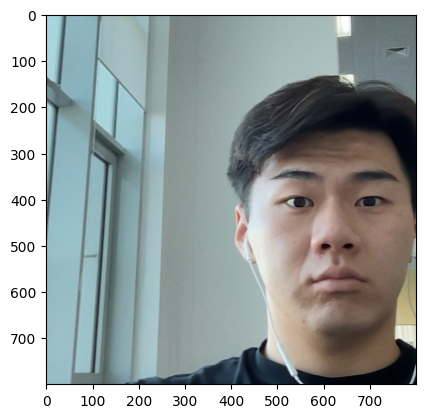

In [48]:
augmented = augmentor(image=img,bboxes=bboxes,class_labels=['face'])
plt.imshow(augmented['image'])

In [49]:
# # Create the label directories if they don't exist
# for folder in ['train','test','validation']:
#     os.makedirs(os.path.join('aug_data', folder,'images'), exist_ok=True)
#     os.makedirs(os.path.join('aug_data', folder,'labels'), exist_ok=True)

In [50]:
for ds in ['train','test','validation']: 
    for image in os.listdir(os.path.join(KAGGLE_PATH, ds, 'images')):
        img = cv2.imread(os.path.join(KAGGLE_PATH, ds, 'images', image))
        img_name = image.split('.')[0]
        label_path = os.path.join(KAGGLE_PATH, ds, 'labels', f'{img_name}.txt')
        if os.path.exists(label_path):
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        try: 
            for x in range(30):
                augmented = augmentor(image=img, bboxes=bboxes, class_labels=['face'])
                cv2.imwrite(os.path.join(KAGGLE_PATH, ds, 'images', f'{img_name}_{x}.jpg'), augmented['image'])
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) != 0: 
                        for i in range(len(augmented['bboxes'])):
                            values = [*augmented['bboxes'][i]]
                            str_list = values[:-1]
                            str_list.insert(0,int(values[-1]))
                            bbox_str = ' '.join(map(str, str_list))
                            with open(os.path.join(KAGGLE_PATH, ds, 'labels', f'{img_name}_{x}.txt'), 'a') as f:
                                f.write(bbox_str)

        except Exception as e:
            print(e)

In [51]:
ln_1='# Train/val/test sets'+newline
ln_2='train: ' +"'"+os.path.join(KAGGLE_PATH, 'train', 'images')+"'"+newline
ln_3='val: ' +"'" +os.path.join(KAGGLE_PATH, 'validation', 'images')+"'"+newline
ln_4='test: ' +"'" +os.path.join(KAGGLE_PATH, 'test', 'images')+"'"+newline
ln_5=newline
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [52]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [53]:
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            _,x_center,y_center,w,h=line.strip().split(" ")
            x0=(float(x_center)-(float(w)/2))*width
            y0=(float(y_center)+(float(h)/2))*height
            x1=(float(x_center)+(float(w)/2))*width
            y1=(float(y_center)-(float(h)/2))*height
            
            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)], 
                               [int(x1),int(y1)], [int(x0),int(y1)]])
#             vertices=vertices.reshape((-1,1,2))
            bbox_list.append(vertices)      
    return tuple(bbox_list)

In [54]:
train_path = os.path.join(KAGGLE_PATH,'train')

In [55]:
training_list = os.listdir(os.path.join(train_path, 'images'))

In [56]:
import copy

/kaggle/working/facedet/train/images/1e30d12e-6110-11ee-a747-d68c087a5dfe_13.jpg /kaggle/working/facedet/train/labels/1e30d12e-6110-11ee-a747-d68c087a5dfe_13.txt
/kaggle/working/facedet/train/images/9c8491d2-6110-11ee-a747-d68c087a5dfe_29.jpg /kaggle/working/facedet/train/labels/9c8491d2-6110-11ee-a747-d68c087a5dfe_29.txt
/kaggle/working/facedet/train/images/188d4338-6110-11ee-a747-d68c087a5dfe_23.jpg /kaggle/working/facedet/train/labels/188d4338-6110-11ee-a747-d68c087a5dfe_23.txt
[Errno 2] No such file or directory: '/kaggle/working/facedet/train/labels/188d4338-6110-11ee-a747-d68c087a5dfe_23.txt'
/kaggle/working/facedet/train/images/9a8769d6-6110-11ee-a747-d68c087a5dfe_6.jpg /kaggle/working/facedet/train/labels/9a8769d6-6110-11ee-a747-d68c087a5dfe_6.txt


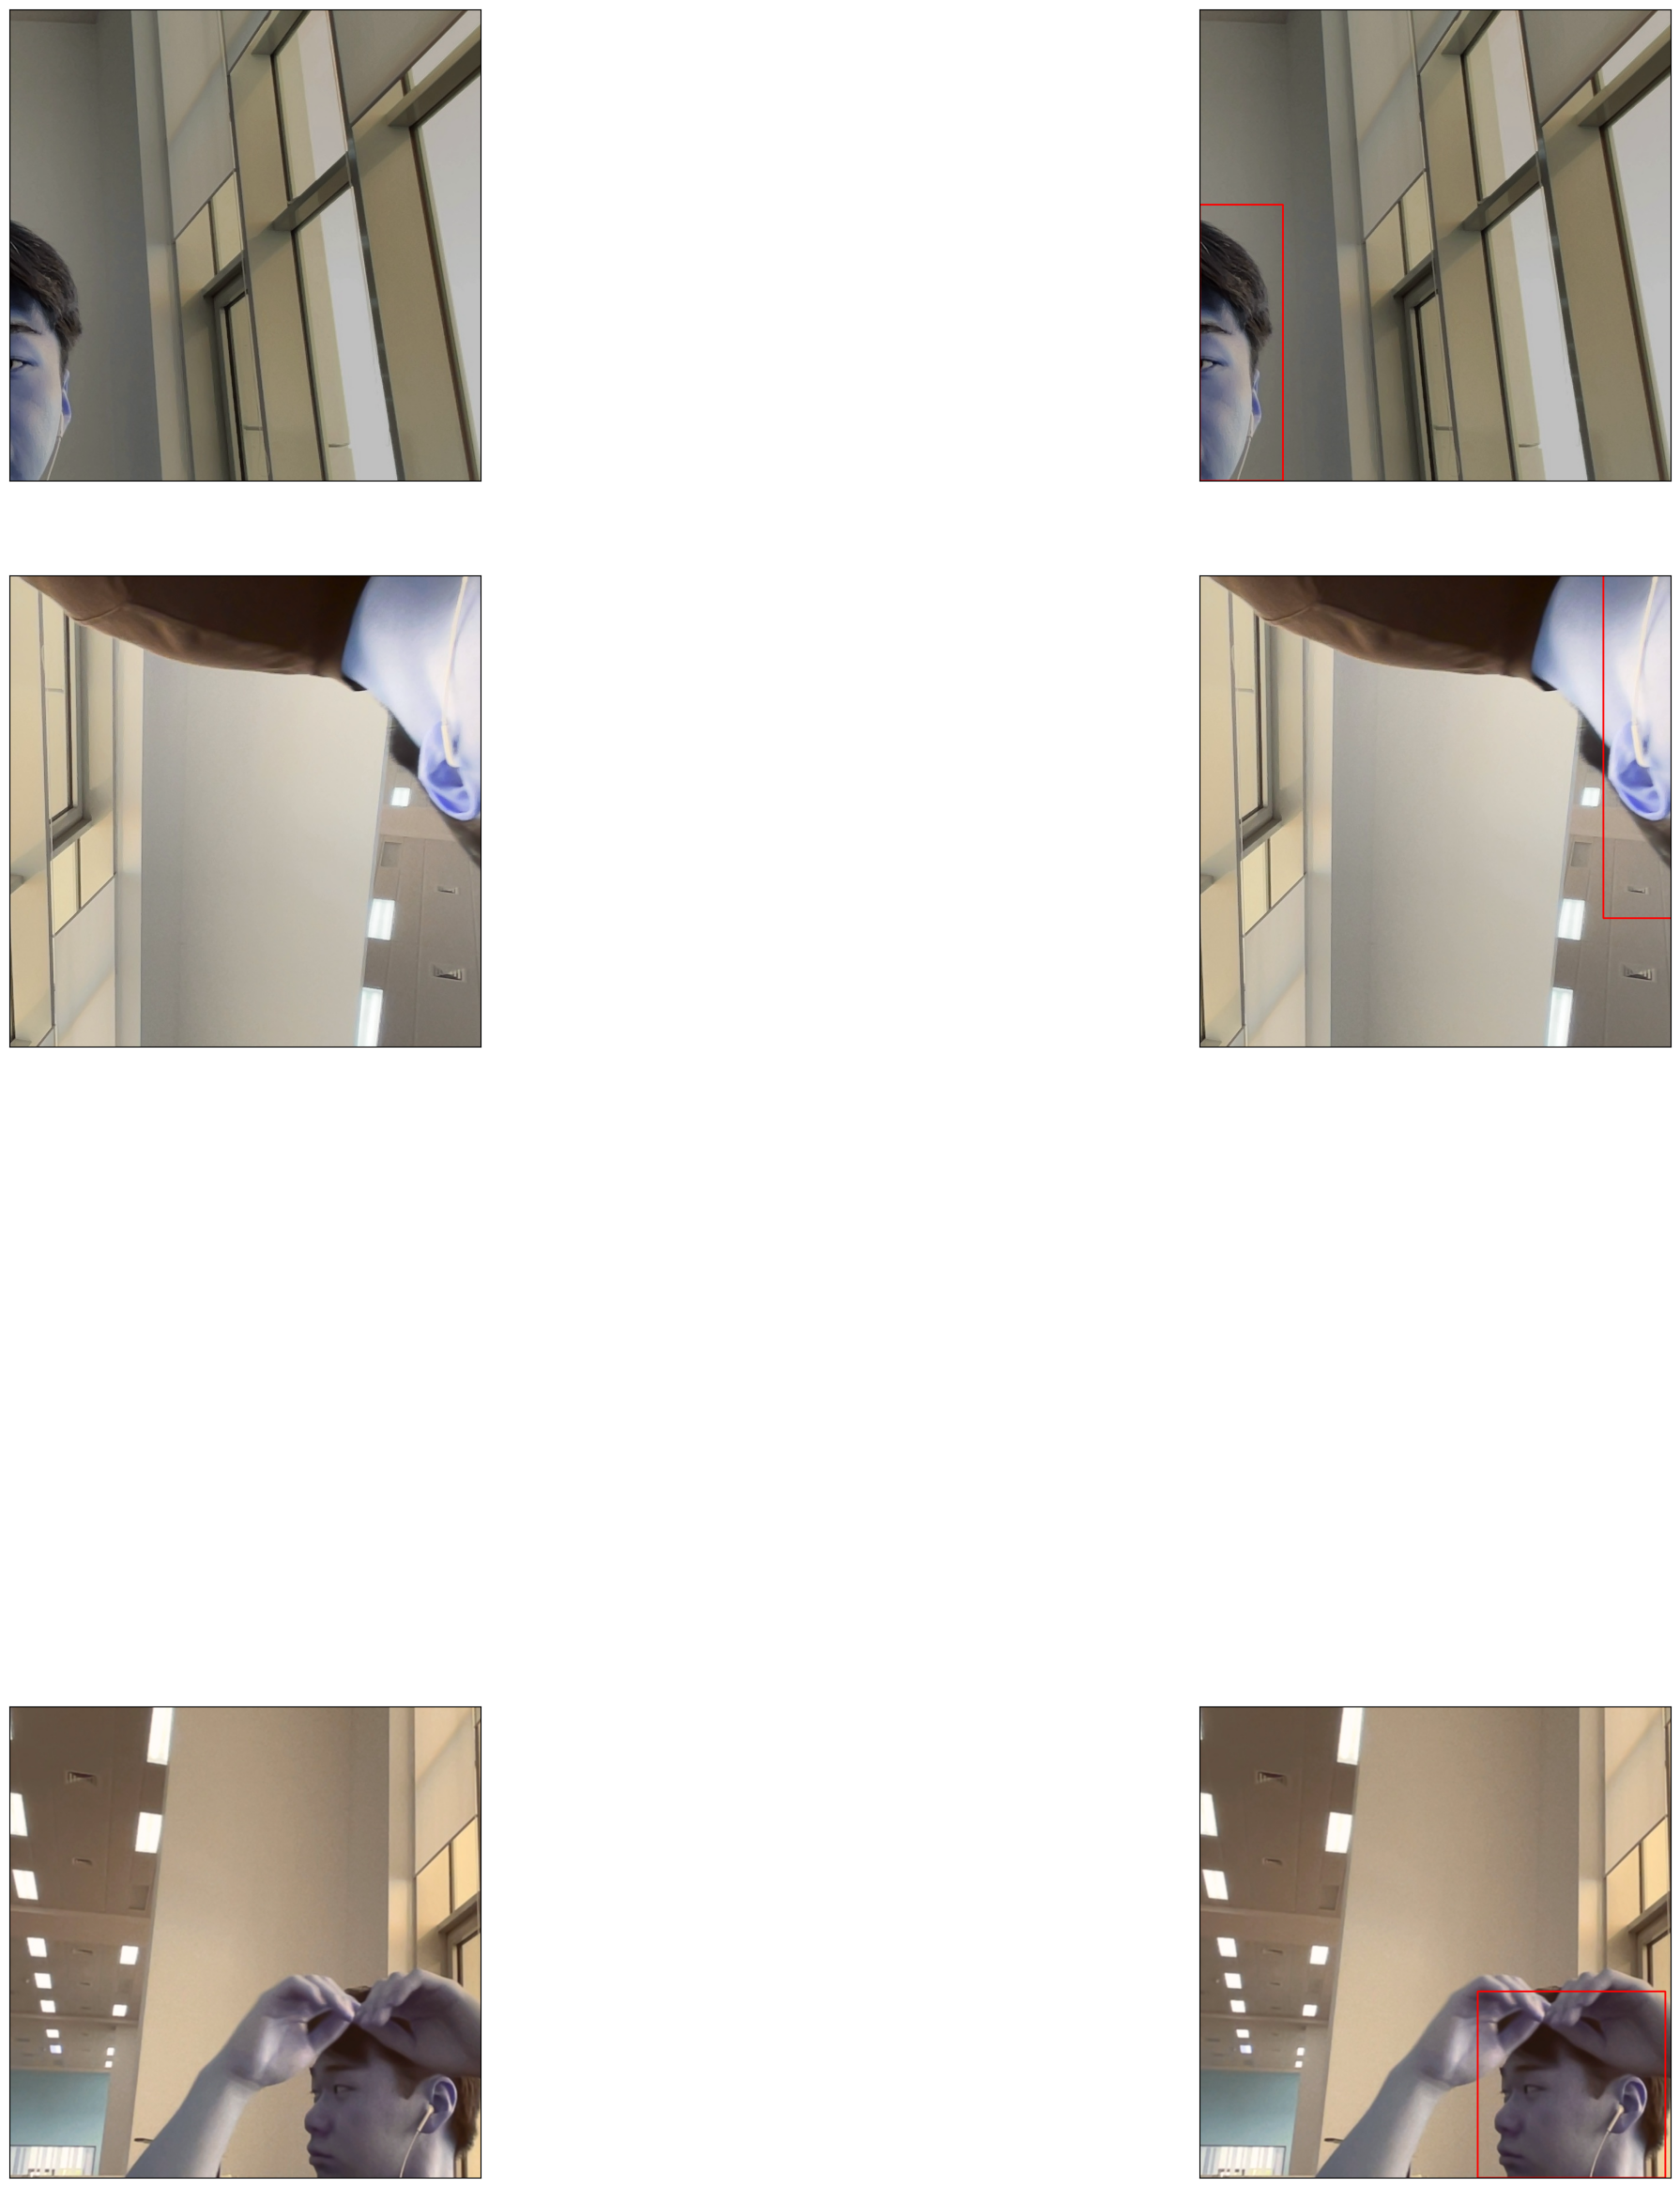

In [57]:
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(training_list)-1)
    img_path=os.path.join(train_path,'images', training_list[k])
    label_path=os.path.join(train_path,'labels', training_list[k].split('.')[0]+'.txt')     
    print(img_path,label_path)
    image=cv2.imread(img_path)
    width, height, _ = np.shape(image)
    try:
        bbox=get_bbox_from_label(label_path)
    except Exception as e:
        print(e)
        continue
    
    image_copy= copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, (255,0,0), 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

In [58]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.9/618.9 kB 11.2 MB/s eta 0:00:00a 0:00:01


In [59]:
from ultralytics import YOLO


In [60]:
# Using YOLO's ptetrained model architecture and weights for training
model=YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [61]:
results=model.train(data=config_path, epochs=100, resume=True, iou=0.5, conf=0.001)

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/working/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimiz

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /kaggle/working/facedet/train/labels... 1624 images, 608 backgrounds, 0 corrupt: 100%|██████████| 2232/2232 [00:01<00:00, 2146.21it/s]
train: New cache created: /kaggle/working/facedet/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/facedet/validation/labels... 242 images, 68 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<00:00, 1798.50it/s]
val: New cache created: /kaggle/working/facedet/validation/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 5

lr/pg0,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▇▇▇███████████████████████████████████
metrics/mAP50-95(B),▁▄▇▆▇█▇█▇█████▇█████▇███████████████████
metrics/precision(B),▁▄██▇█▇▇██████████████▇▇████████▇███████
metrics/recall(B),▁▅▇▆▇███▇████▇████████▇█████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁


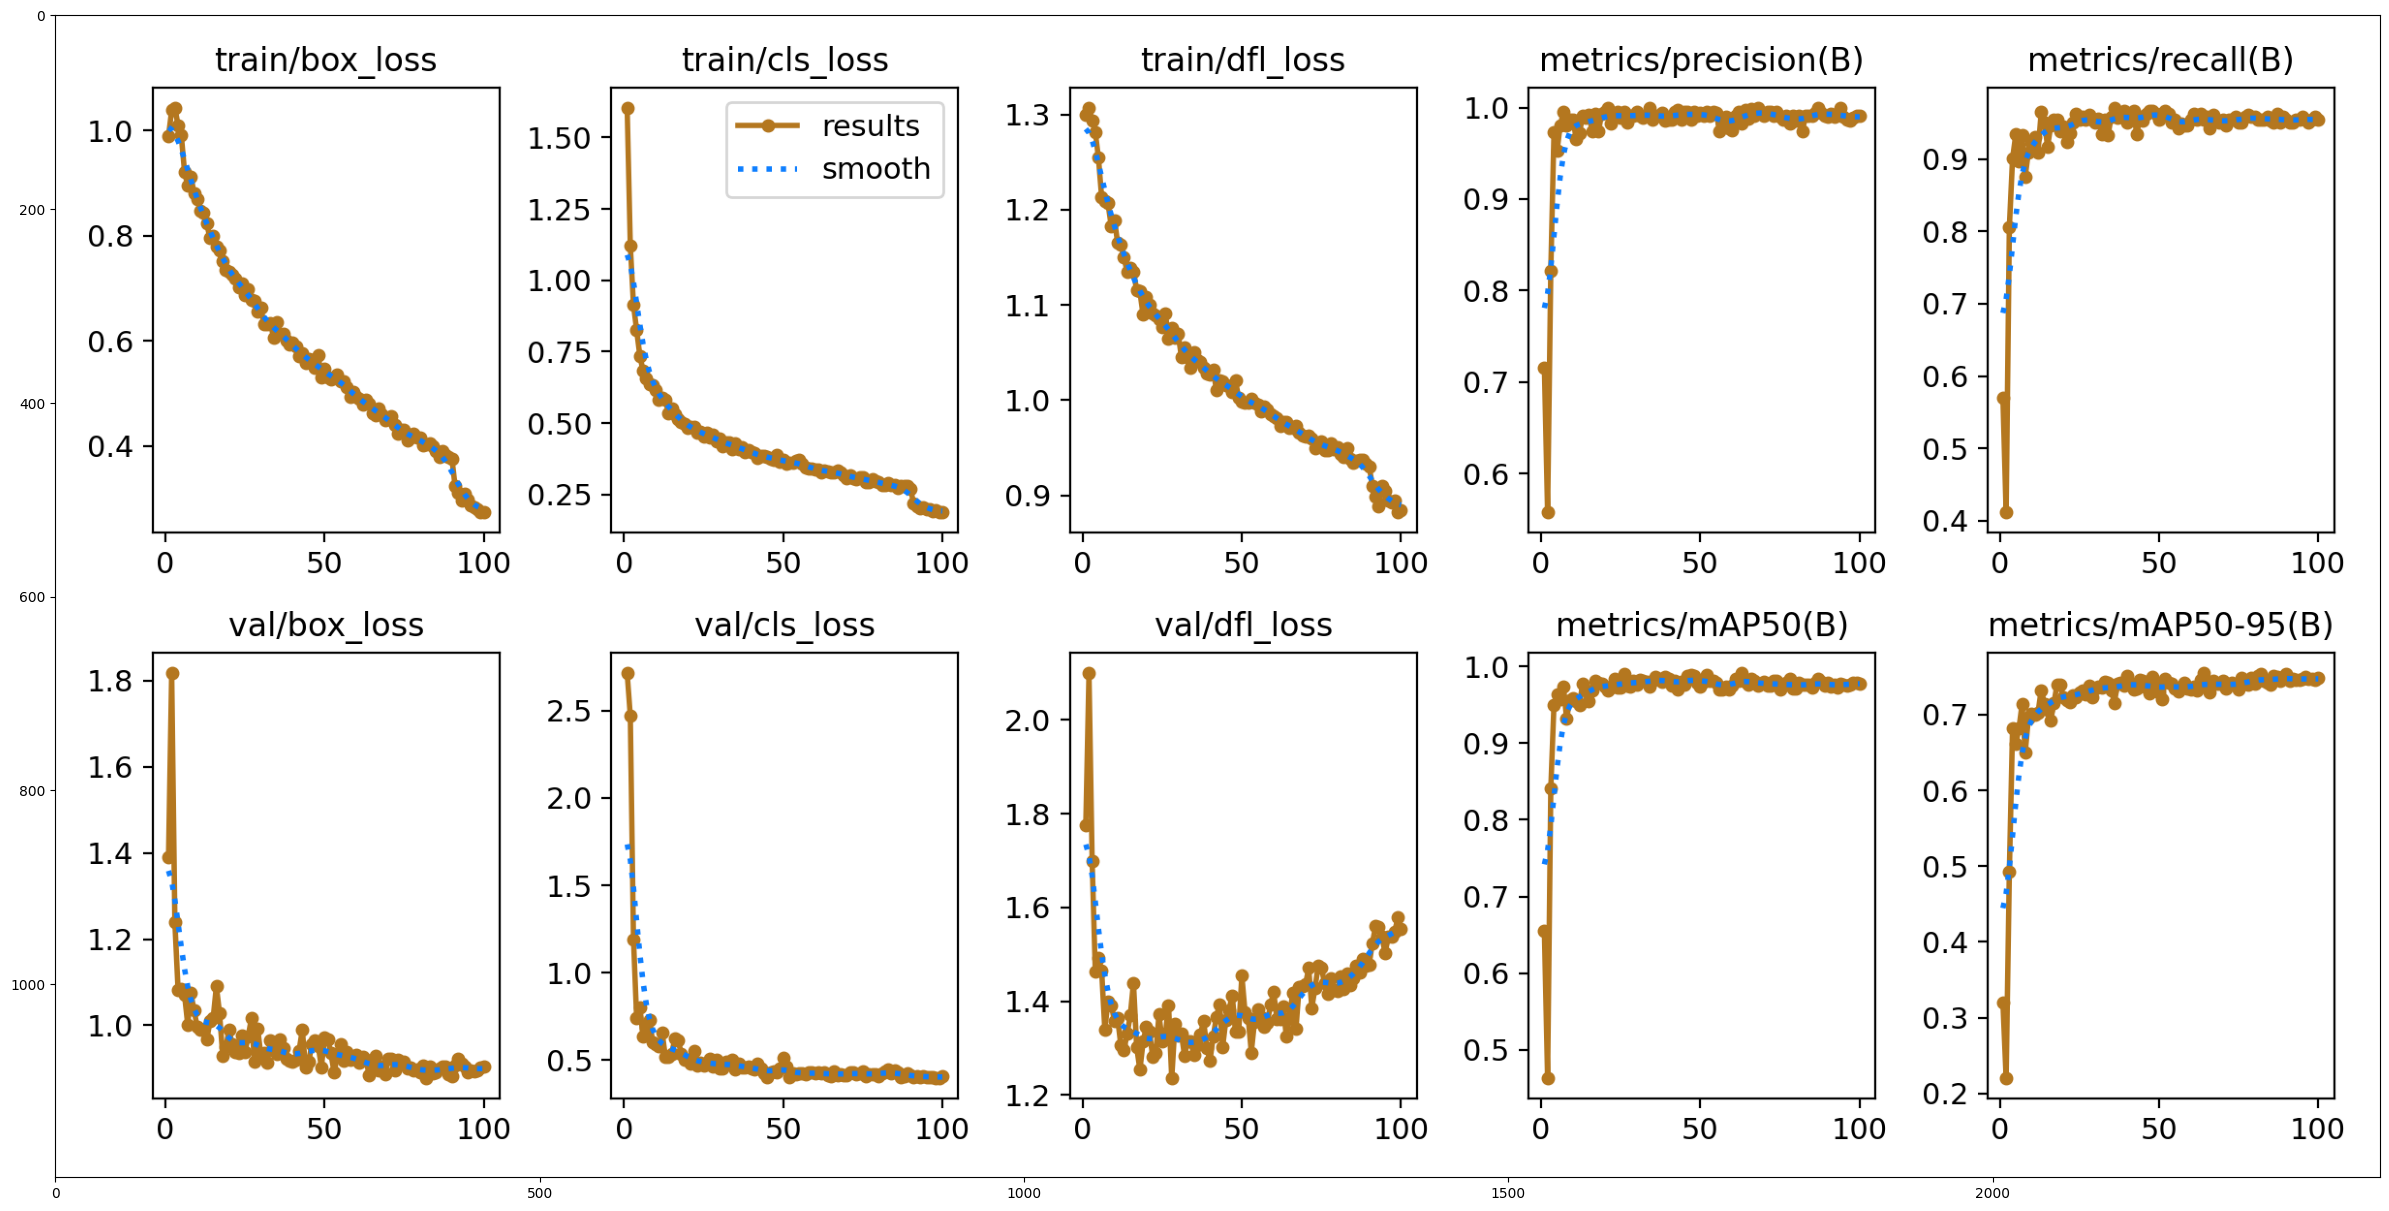

In [62]:
plt.figure(figsize=(30,30))
trainingresult_path=os.path.join(curr_path, 'runs', 'detect', 'train')
results_png=cv2.imread(os.path.join(trainingresult_path,'results.png'))
plt.imshow(results_png)

In [63]:
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [64]:
train_metrics, train_map50=evaluate_map50(model, config_path, dataset='train')


Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/facedet/train/labels.cache... 1624 images, 608 backgrounds, 0 corrupt: 100%|██████████| 2232/2232 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:34<00:00,  4.01it/s]
                   all       2232       1624       0.99      0.979      0.992      0.934
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


The mAP of model on train dataset is 0.992


In [65]:
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')


Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
val: Scanning /kaggle/working/facedet/validation/labels.cache... 242 images, 68 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                   all        310        242      0.997      0.955       0.98      0.755
Speed: 1.5ms preprocess, 5.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val2


The mAP of model on val dataset is 0.98


In [66]:
test_metrics, test_map50=evaluate_map50(model, config_path, dataset='test')


Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
val: Scanning /kaggle/working/facedet/test/labels... 172 images, 76 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<00:00, 2319.78it/s]
val: New cache created: /kaggle/working/facedet/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                   all        248        172      0.981      0.953      0.974      0.766
Speed: 2.8ms preprocess, 5.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val3


The mAP of model on test dataset is 0.974


In [67]:
!zip -r results.zip /kaggle/working/runs/detect/train

  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/results.png (deflated 9%)
  adding: kaggle/working/runs/detect/train/labels_correlogram.jpg (deflated 42%)
  adding: kaggle/working/runs/detect/train/events.out.tfevents.1696826728.950b989ade57.28.0 (deflated 75%)
  adding: kaggle/working/runs/detect/train/val_batch2_labels.jpg (deflated 12%)
  adding: kaggle/working/runs/detect/train/train_batch12602.jpg (deflated 10%)
  adding: kaggle/working/runs/detect/train/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/runs/detect/train/confusion_matrix.png (deflated 41%)
  adding: kaggle/working/runs/detect/train/args.yaml (deflated 51%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/train/weights/best.pt (deflated 9%)
  adding: kaggle/working/runs/detect/train/weights/last.pt (deflated 9%)
  adding: kaggle/working/runs/detect/train/val_batch1_labels.jpg (deflated 13%)
 